# Import the Packages and Configure the Plot Settings

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from statsmodels.graphics.gofplots import ProbPlot

plt.style.use('seaborn') # pretty matplotlib plots

plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

# Load in the Data Set

In [2]:
auto = pd.read_csv('Auto.csv', na_values = ['?'])
auto.dropna(inplace = True)
auto.reset_index(drop = True, inplace = True)

# Create a Model to Estimate MPG (in R-Style)

In [3]:
model_f = 'mpg ~ cylinders + \
                 displacement + \
                 horsepower + \
                 weight + \
                 acceleration + \
                 year + \
                 origin'

model = smf.ols(formula = model_f, data = auto)
model_fit = model.fit()

# Create the Necessary Features for the Residual Plots

In [4]:
# fitted values (need a constant term for intercept)
model_fitted_y = model_fit.fittedvalues

# model residuals
model_residuals = model_fit.resid

# normalised residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal

# absolute squared normalised residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag

# Cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

# Plot the Residuals vs. Fitted Graph

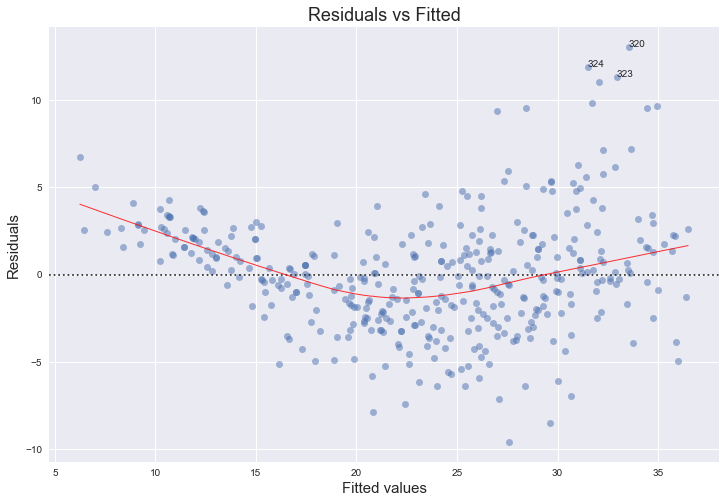

In [5]:
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)

plot_lm_1.axes[0] = sns.residplot(model_fitted_y, 'mpg', data = auto, lowess = True, scatter_kws = {'alpha': 0.5}, 
                                  line_kws = {'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

# annotations
abs_resid = model_abs_resid.sort_values(ascending=False)
abs_resid_top_3 = abs_resid[:3]

for i in abs_resid_top_3.index:
    plot_lm_1.axes[0].annotate(i, xy = (model_fitted_y[i], model_residuals[i]));

This graph is used to check for the assumption of the residuals having 0 mean and no relationship to the fitted values. You are lookin for the red line to be flat and as close to 0 as possible.

# Plot the Theoretical Quantiles vs. the Standardised Residuals Graph

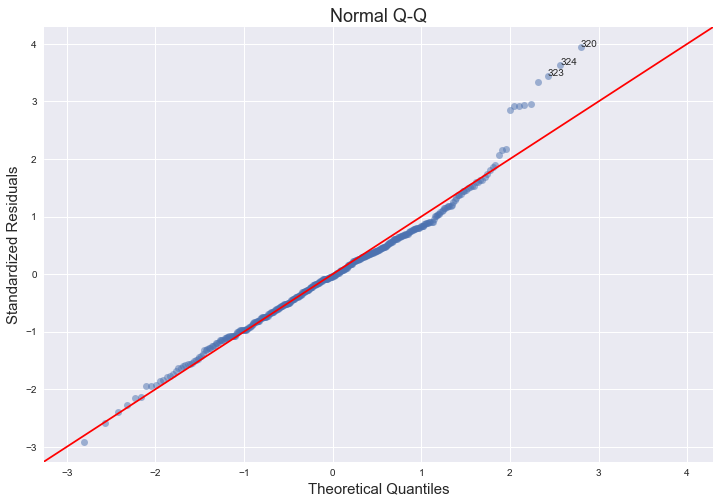

In [6]:
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line = '45', alpha = 0.5, color = '#4C72B0', lw = 1)

plot_lm_2.set_figheight(8)
plot_lm_2.set_figwidth(12)

plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardised Residuals');

# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]

for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i, xy = (np.flip(QQ.theoretical_quantiles, 0)[r], model_norm_residuals[i]));

The graph is used to check for normality in the standardised residuals. You are looking for the dots to lie along the red line, all the way along. The red line represents the theoretical distribution that the residuals should have. For help interpreting the graph, see https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot

# Plot the Fitted Values vs. Square Root of the Standardised Residuals Graph

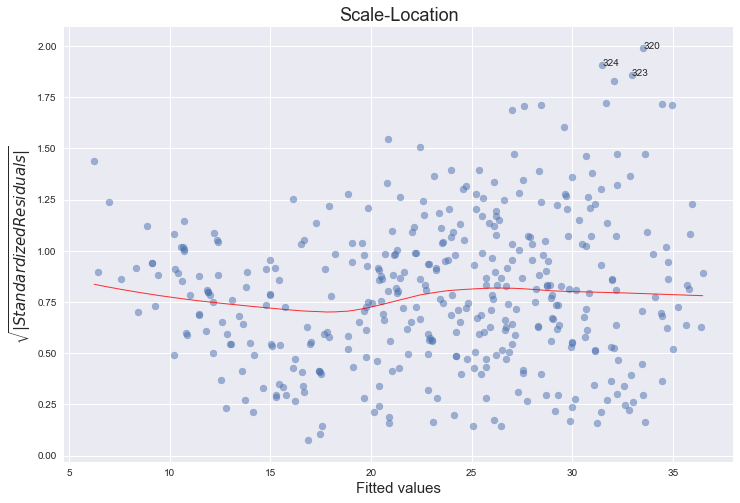

In [7]:
plot_lm_3 = plt.figure(3)
plot_lm_3.set_figheight(8)
plot_lm_3.set_figwidth(12)

plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha = 0.5)
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, scatter = False, ci = False, lowess = True,
            line_kws = {'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted Values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardised Residuals|}$');

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]

for i in abs_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(i, xy = (model_fitted_y[i], model_norm_residuals_abs_sqrt[i]));

The graph is to check the assumption of homoskedasticity of the residuals. It plots the spread of residuals are spread equally along the range of predictors. You are looking for a flat red line through all of the points.

# Plot the Cook Distance Graph

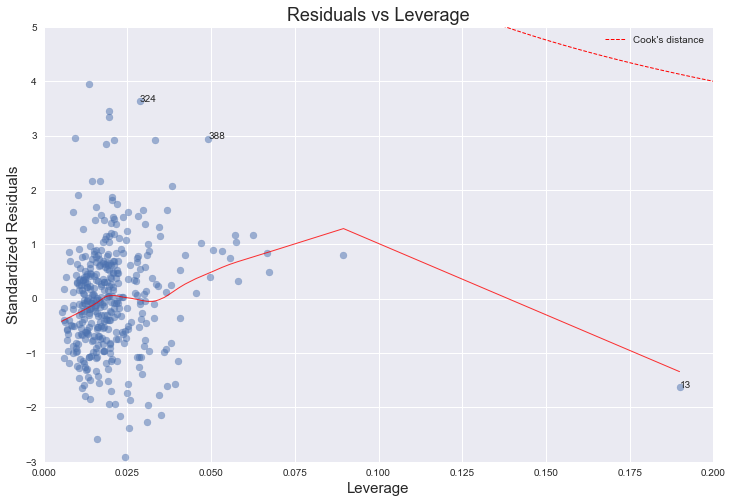

In [8]:
plot_lm_4 = plt.figure(4)
plot_lm_4.set_figheight(8)
plot_lm_4.set_figwidth(12)

plt.scatter(model_leverage, model_norm_residuals, alpha = 0.5)
sns.regplot(model_leverage, model_norm_residuals, scatter = False, ci = False, lowess = True,
            line_kws = {'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_4.axes[0].set_xlim(0, 0.20)
plot_lm_4.axes[0].set_ylim(-3, 5)
plot_lm_4.axes[0].set_title('Residuals vs Leverage')
plot_lm_4.axes[0].set_xlabel('Leverage')
plot_lm_4.axes[0].set_ylabel('Standardised Residuals')

# annotations
leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]

for i in leverage_top_3:
    plot_lm_4.axes[0].annotate(i, xy = (model_leverage[i], model_norm_residuals[i]))
    
# shenanigans for Cook's distance contours
def graph(formula, x_range, label = None):
    x = x_range
    y = formula(x)
    plt.plot(x, y, label = label, lw = 1, ls = '--', color = 'red')

p = len(model_fit.params) # number of model parameters

graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), np.linspace(0.001, 0.200, 50), 'Cook\'s distance') # 0.5 line
graph(lambda x: np.sqrt((1 * p * (1 - x)) / x), np.linspace(0.001, 0.200, 50)) # 1 line
plt.legend(loc = 'upper right');

The Cook's distance graph shows whether a particular value is an outlier that may negatively impact the results of the regression. The distance is calculated by removing the ith point from the regression and re-running it and seeing how much the regression values change.
<br>
In this case, the pattern is irrelevant, you are just looking for points that fall on the outside of the dotted lines.

https://data.library.virginia.edu/diagnostic-plots/